In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

In [32]:
from keras.preprocessing import image
from data_preprocessor.PreProcessImgData import PreProcessImgData

In [33]:
image_path_samples = '../train_camVid/*.png'
image_path_labels = '../LabeledApproved_full/*.png'
# image_path_samples = 'C:/Krishna/DataSets/cam_vid_semantic/train_samples/*.png'
# image_path_labels = 'C:/Krishna/DataSets/cam_vid_semantic/train_labels/*.png'

target_width = 256
target_height = 256
labels_dict = [[0, 0, 0],[128, 64, 128],[128, 0, 0]]
#labels_dict = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],[128,64,128]]
#labels_dict = [[128,64,128]]

In [34]:
p = PreProcessImgData(image_path_samples,
                      image_path_labels,
                      len(labels_dict), target_width, target_height, labels_dict,False)

sorted_samples = sorted(p.file_list_samples)
sorted_labels = sorted(p.file_list_labels)

In [36]:
from sklearn.model_selection import train_test_split


train_samples,test_samples,train_labels,test_labels = train_test_split(sorted_samples,sorted_labels,test_size=0.33, random_state=42)

In [37]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import *
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import *


In [38]:
## Model for FCNNs with skip connections

img_input = Input(shape=(256,256,3))

conv1 = Conv2D(64,(3,3),activation= 'relu',padding='same')(img_input)
pool1 = MaxPool2D(pool_size=(2,2),padding='same')(conv1)

conv2 = Conv2D(128,(3,3),activation= 'relu',padding='same')(pool1)
pool2 = MaxPool2D(pool_size=(2,2),padding='same')(conv2)

conv3 = Conv2D(256,(3,3),activation= 'relu',padding='same')(pool2)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPool2D(pool_size=(2,2),padding='same')(drop3)

conv4 = Conv2D(512,(3,3),activation= 'relu',padding='same')(pool3)
drop4 = Dropout(0.5)(conv4)

# up_sample4 = UpSampling2D((2,2))(drop4)
# conv_transpose4 = Conv2DTranspose(512,(3,3),activation='relu',padding='same')(up_sample4)
# skip_connected_4 = Add()([conv_transpose4,drop4])

up_sample3 = UpSampling2D((2,2))(drop4)
conv_transpose3 = Conv2DTranspose(256,(3,3),activation='relu',padding='same')(up_sample3)
skip_connected_3 = Add()([conv_transpose3,drop3])

up_sample2 = UpSampling2D((2,2))(skip_connected_3)
conv_transpose2 = Conv2DTranspose(128,(3,3),activation='relu',padding='same')(up_sample2)
skip_connected_2 = Add()([conv_transpose2,conv2])

up_sample1 = UpSampling2D((2,2))(skip_connected_2)
conv_transpose1 = Conv2DTranspose(64,(3,3),activation='relu',padding='same')(up_sample1)
out_layer2 = Conv2D(len(labels_dict),(1,1),padding='same',kernel_regularizer=l2(0.001),activity_regularizer=l2(0.001))(conv_transpose1)
#out_layer0 = Lambda(p.depth_softmax)(out_layer1)
out_layer1 = Reshape((target_width*target_height,len(labels_dict)))(out_layer2)
out_layer0 = Activation('softmax')(out_layer1)
model = Model(input = img_input,output = out_layer1)


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 128 73856       max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

/home/aind2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [39]:
model.compile(optimizer = Adam(lr= 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Epoch 1/1
20/20 [==============================] - 94s 5s/step - loss: 1.7175 - acc: 0.1959


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


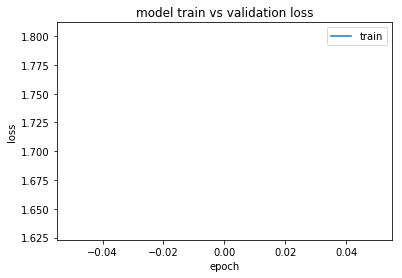

In [48]:
check_pointer = ModelCheckpoint('best_weights/best_weights.hdf5',verbose=1,save_best_only=True)
#history = model.fit(train_samples_array,train_labels_array,epochs=5,verbose=1,validation_split=0.1, batch_size=5,callbacks=[check_pointer])
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=1,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
from PIL import Image

pred_array = model.predict(np.expand_dims(image.load_img(train_samples[2], target_size=(256, 256)),axis=0)/255)

print(pred_array.shape)


(1, 65536, 3)


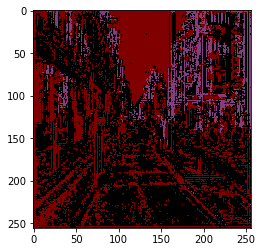

In [50]:
from matplotlib.pyplot import imshow

%matplotlib inline

pred_img = p.reduce_to_img(np.squeeze(pred_array).reshape((target_width,target_height,3)))

imshow(Image.fromarray((pred_img).astype('uint8')))


In [30]:
np.min(pred_array)

-0.015410425

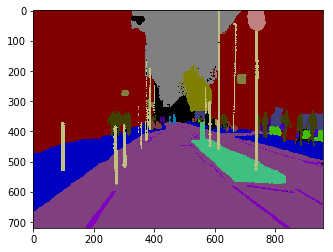

In [28]:
imshow(Image.open(train_labels[2]))

(256, 256, 3)


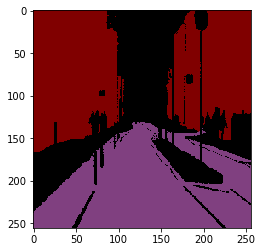

In [29]:
a = p.label_to_array(np.array(p.load(train_labels[2])))

print(a.shape)

lab_img = p.reduce_to_img(np.squeeze(a))

imshow(Image.fromarray((lab_img).astype('uint8')))

Epoch 1/1
20/20 [==============================] - 93s 5s/step - loss: 700.1666 - acc: 0.3932


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


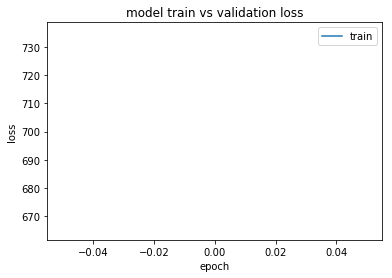

In [30]:
check_pointer = ModelCheckpoint('best_weights/best_weights.hdf5',verbose=1,save_best_only=True)
#history = model.fit(train_samples_array,train_labels_array,epochs=5,verbose=1,validation_split=0.1, batch_size=5,callbacks=[check_pointer])
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=1,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

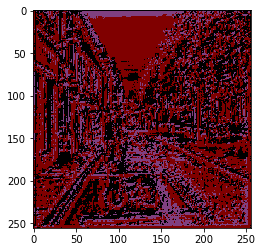

In [31]:
pred_array = model.predict(np.expand_dims(image.load_img(train_samples[400], target_size=(256, 256)),axis=0))
pred_img = p.reduce_to_img(np.squeeze(pred_array).reshape((target_width,target_height,3)))

imshow(Image.fromarray((pred_img).astype('uint8')))


(256, 256, 3)


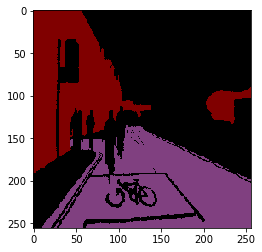

In [32]:
b = p.label_to_array(np.array(p.load(train_labels[400])))

print(a.shape)

lab_img = p.reduce_to_img(np.squeeze(b))

imshow(Image.fromarray((lab_img).astype('uint8')))

Epoch 1/2
20/20 [==============================] - 92s 5s/step - loss: 700.1586 - acc: 0.4488
Epoch 2/2


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 91s 5s/step - loss: 700.1573 - acc: 0.4792


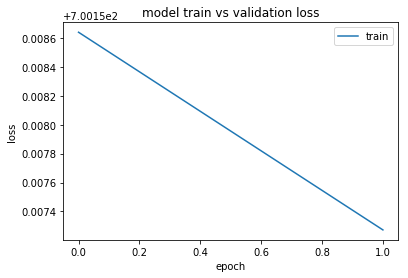

In [33]:
check_pointer = ModelCheckpoint('best_weights/best_weights.hdf5',verbose=1,save_best_only=True)
#history = model.fit(train_samples_array,train_labels_array,epochs=5,verbose=1,validation_split=0.1, batch_size=5,callbacks=[check_pointer])
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=2,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

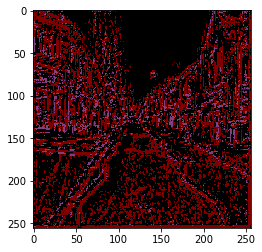

In [35]:
pred_array = model.predict(np.expand_dims(image.load_img(train_samples[1], target_size=(256, 256)),axis=0))
pred_img = p.reduce_to_img(np.squeeze(pred_array).reshape((target_width,target_height,3)))

imshow(Image.fromarray((pred_img).astype('uint8')))

(256, 256, 3)


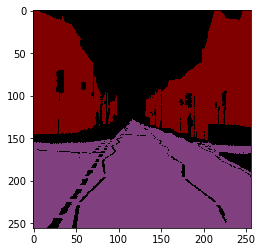

In [36]:
a = p.label_to_array(np.array(p.load(train_labels[1])))

print(a.shape)

lab_img = p.reduce_to_img(np.squeeze(a))

imshow(Image.fromarray((lab_img).astype('uint8')))